### Student Name: Aidan Keeshan
### Student ID: 18200117

# Lab 4: Comparison of Classifiers

## Task 1 (CS5062)

    Watch the video playlist CS5062-E-tivity4 (ca. 40 min).
    Read the article How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python.
    Use the following files (available in the GitLab repository):
        Lab 4 - Comparison of Classifiers - Main.ipynb - This is the main example notebook to follow these two weeks. It contains code for training and evaluating SVM and Naïve Bayes classifiers.
        Lab4_Functions.ipynb - This notebook contains some functions used in the man example notebook. They have been put in a separate file to keep the main notebook easier to follow.
        seeds_dataset_binary.csv - This is the data set used in the main example notebook.
        data set loans_et4.csv. This is a modified version of the loans data set with 1 for Loan_Status = Yes and 0 for Loan_Status = No. You are asked to work with this data set in Tasks 1-3.
    Replicate the classifier training and evaluation demonstrated in the main example notebook Lab 4 - Comparison of Classifiers - Main.ipynb but with the data set loans_et4.csv and target attribute Loan_Status.   
    Then train another probabilistic classifier with loans_et4.csv add compare it to both SVM and Naïve Bayes. For this third classifier, you can pick any scikit-learn probabilistic classification algorithm apart from SVM and Naive Nayes.   
    Summarise your conclusions (max 150 words in a markdown cell).


This notebook demonstrates how to choose the best out of a few alternative classification models by applying cross-validation and comparing the accuracy of prediction, the F1-scores and the ROC curves of the classification models.

Here we use a _modified version_ of the __seeds data set__ (see https://archive.ics.uci.edu/ml/datasets/seeds), which is one of the public UCI data sets. Each example is a seed described by a few numerical attributes. The target variable for classification (in this example) is the type of the seed, which can be either 1 or 0. Class 1 are the seeds of a particular type that, we can assume, is important to learn to predict correctly, while class 0 are all other seeds.

In this example, we use 5-fold cross-validation. Empirical evidence suggests that 10 folds are probably the best choice for cross-validation, i.e. 10-fold cross-validation. However, since this data set is relatively small, and 1/10 of it is only 21 examples, it is sensible to use larger folds for testing. Thus, we demonstrate the comparison of classifiers with 5-fold cross-validation.

The code in this notebook was originally inspired by the example at https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html.

## A. Preparation

### Import Python modules

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from scipy import interp

### Import evaluation and plotting functions

In [2]:
%run ./Lab4_Functions.ipynb

### Load and prepare the dataset for training and evaluating a classifier
Feel free to apply any other pre-processing technique at this point.

In [23]:
lab4_df = pd.read_csv("loans_et4.csv")
lab4_df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.797917,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


In [24]:
# target attribute
target = lab4_df['Loan_Status']

# predictor attributes
predictors = lab4_df.drop('Loan_Status', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

### Prepare an array of 100 equally spaced false-positive-rate values between 0 and 1
To be used as an x-axis in ROC curve plots.

In [25]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

## B. Evaluation and Comparison of Classifiers

### Train a Probablistic SVM Classifier

In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM = evaluate_classifier(folds=5, 
                                                                        p=predictors, t=target, 
                                                                        classifier=SVM_classifier, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

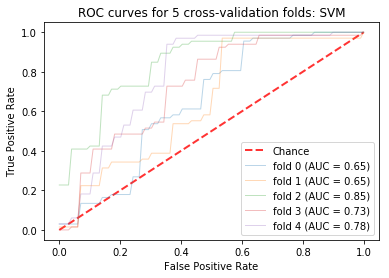

In [78]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

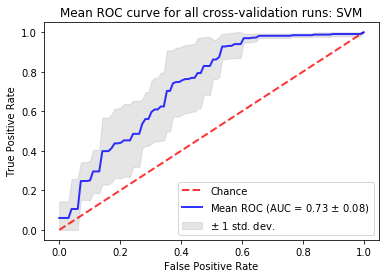

In [79]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

### Train a Naive Bayes Classifier

In [29]:
# Create a Naive Bayes classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_NB, f1_scores_NB, tprs_NB, aucs_NB = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=NB_classifier, 
                                                                    mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

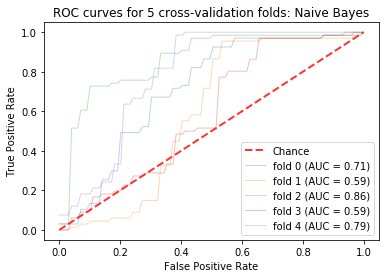

In [30]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

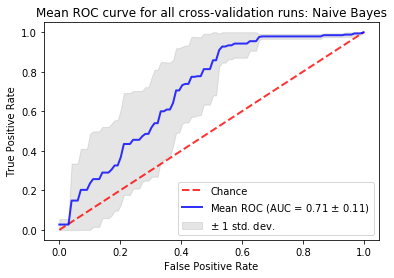

In [31]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

### Train a Random Forest Classifier

In [75]:
# Create a Random Forest classifier object with default parameters
RF_classifier = RandomForestClassifier(n_estimators = 10)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF, f1_scores_RF, tprs_RF, aucs_RF = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=RF_classifier, 
                                                                    mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

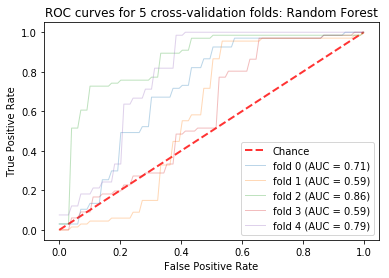

In [76]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Random Forest')

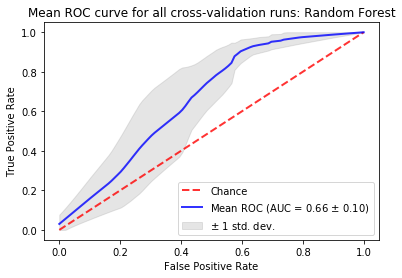

In [77]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF, aucs_RF, 'Random Forest')

In [ ]:
### Train a Logistic Regression Classifier

In [82]:
# Create a Logistic Regression classifier object with default parameters
LR_classifier = LogisticRegression(solver ='lbfgs',fit_intercept=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_LR, f1_scores_LR, tprs_LR, aucs_LR = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=LR_classifier, 
                                                                    mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

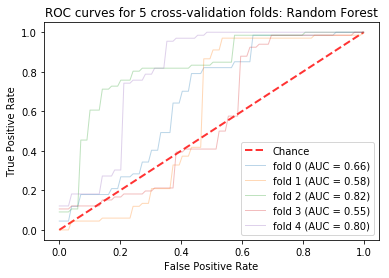

In [83]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_LR, aucs_LR, 'Logistic Regression')

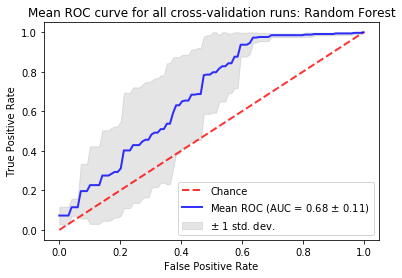

In [84]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_LR, aucs_LR, 'Logistic Regression')

### Compare All Trained Classifiers

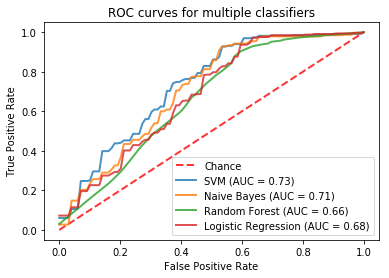

In [85]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_NB, axis=0),np.mean(tprs_RF, axis=0),np.mean(tprs_LR, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_NB), np.mean(aucs_RF), np.mean(aucs_LR)]), 
                              np.array(['SVM', 'Naive Bayes', 'Random Forest','Logistic Regression' ]))

In [87]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB, 'Random Forest' : accuracies_RF, 'Logistic Regression' : accuracies_LR})

In [88]:
accuracies_df.describe()

,SVM,Naive Bayes,Random Forest,Logistic Regression
count,5.000000,5.000000,5.000000,5.000000
mean,0.808403,0.791670,0.698409,0.808403
std,0.029567,0.053465,0.093614,0.029567
min,0.778947,0.715789,0.587629,0.778947
25%,0.783505,0.762887,0.628866,0.783505
50%,0.812500,0.804124,0.705263,0.812500
75%,0.814433,0.822917,0.747368,0.814433
max,0.852632,0.852632,0.822917,0.852632


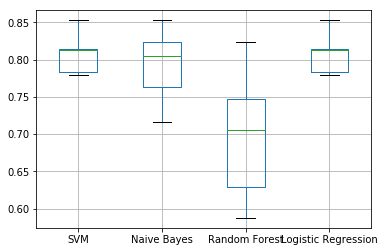

In [89]:
accuracies_df.boxplot()
plt.show()

In [92]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : f1_scores_SVM, 'Naive Bayes' : f1_scores_NB, 'Random Forest' : f1_scores_RF, 'Logistic Regression' : f1_scores_LR})

In [93]:
f1_scores_df.describe()

,SVM,Naive Bayes,Random Forest,Logistic Regression
count,5.000000,5.000000,5.000000,5.000000
mean,0.876278,0.860583,0.776810,0.876278
std,0.017193,0.036598,0.087831,0.017193
min,0.860927,0.808511,0.661017,0.860927
25%,0.860927,0.839161,0.723077,0.860927
50%,0.878378,0.872483,0.784615,0.878378
75%,0.878378,0.882759,0.830986,0.878378
max,0.902778,0.900000,0.884354,0.902778


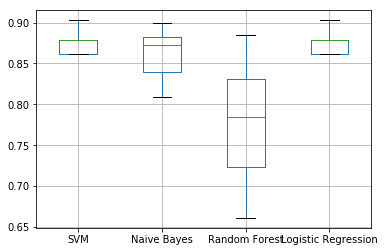

In [94]:
f1_scores_df.boxplot()
plt.show()

#### Conclusion

In this example, both the SVM and the Naive Bayes classifiers have mean accuracy approximately 88%, which is quite high. The ROC curves do not suggest a clear winner, although it can be noted that Naive Bayes can achieve TPR above 80% for a lower FPR than SVM. On the other hand, the accuracy of the five folds of Naive Bayes show higher variance than the accuracy of the five folds of SVM, and low variance is desirable. Still, the lowest accuracy of Naive Bayes is above 75% which is not bad. Similar observation can be made about the F1 score. Naive Bayes has a higher mean F1 score but also higher variance. Since both SVM and Naive Bayes have high mean accuracy, high mean F1 score and a very similar AUC, while SVM appears to have visibly lower variance than Naive Bayes, we can conclude that perhaps SVM is a safer choice for a best model. 

It will be interesting to plot precision and recall for a more detailed comparison. Since the two classes are not well balanced (1/3 of the examples are in class 1), a precision-recall curve a more detailed study of the precision and recall can provide better information than the ROC curves for picking the best model.

## C. FInal Model

Assuming SVM was chosen, now we can train a final (to be potentially deployed) SVM model with the whole dataset:

In [95]:
model = SVM_classifier.fit(predictors, target)

Use the model to predict the type of three new seeds:

In [96]:
new_seeds = np.array([[0.4,0.5,0.6,0.5,0.5,0.2,0.3,0.5,0.5,0.2,0.3], [0.0,1.0,0.0,1.0,0.5,0.5,0.2,0.5,0.5,0.2,0], [0.2,0.2,0.2,1.0,0.2,0.2,0.2,0.2,0.2,0.2,0]])
new_seeds.shape

(3, 11)

In [97]:
# Probabilistic prediction
np.round(model.predict_proba(new_seeds), 2)
# Note: 
#   - the first column are the probabilities for the three new seeds to belong to class 0
#   - the second column are the probabilities for the three new seeds to belong to class 1

array([[0.83, 0.17],
       [0.81, 0.19],
       [0.81, 0.19]])

In [98]:
# Exact prediction
model.predict(new_seeds)

array([0, 0, 0])